In [1]:
%pip install torch transformers datasets wandb --upgrade

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 881.9 MB 5.6 kB/s  eta 0:00:015
     |████████████████████████████████| 3.1 MB 82.2 MB/s 
     |████████████████████████████████| 290 kB 77.3 MB/s 
     |████████████████████████████████| 1.7 MB 58.0 MB/s 
     |████████████████████████████████| 76 kB 7.4 MB/s 
     |████████████████████████████████| 287 kB 57.3 MB/s 
     |████████████████████████████████| 287 kB 51.7 MB/s 
     |████████████████████████████████| 287 kB 62.9 MB/s 
     |████████████████████████████████| 285 kB 63.0 MB/s 
     |████████████████████████████████| 270 kB 61.7 MB/s 
     |████████████████████████████████| 269 kB 83.3 MB/s 
     |████████████████████████████████| 264 kB 81.9 MB/s 
     |████████████████████████████████| 56 kB 6.4 MB/s 
     |████████████████████████████████| 542 kB 78.7 MB/s 
     |████████████████████████████████| 542 kB 59.6 MB/s eta 0:00:01
     |█████████████████████████

In [46]:
%pip install scipy --upgrade

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 28.5 MB 2.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

nli_checkpoint = 'cointegrated/rubert-base-cased-nli-threeway'
nli_tokenizer = AutoTokenizer.from_pretrained(nli_checkpoint)
nli_model = AutoModelForSequenceClassification.from_pretrained(nli_checkpoint)

In [11]:
def perform_nli(premise, hypothesis):
    with torch.inference_mode():
        out = nli_model(**nli_tokenizer(premise, hypothesis, return_tensors='pt'))
        proba = torch.softmax(out.logits, -1).cpu().numpy()[0]
    return {v: proba[k] for k, v in nli_model.config.id2label.items()}

In [12]:
from transformers import AutoTokenizer, AutoModel
import torch

sbert_tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
sbert_model = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru")

In [13]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def get_embedding(sentences):
    encoded_input = sbert_tokenizer(sentences, padding=True, truncation=False, return_tensors='pt')

    with torch.inference_mode():
        model_output = sbert_model(**encoded_input)

    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    return sentence_embeddings

In [22]:
from transformers import GPT2LMHeadModel

gpt_tokenizer = AutoTokenizer.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2')
gpt_model = GPT2LMHeadModel.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [99]:
def estimate_perplexity(text):
    inputs = gpt_tokenizer(text, return_tensors="pt")
    with torch.inference_mode():
        loss = gpt_model(**inputs, labels=inputs["input_ids"]).loss
    return loss.item()

In [38]:
test_embeds = torch.load("data/test.pt")
test_text = "На ногах у Ивана резиновые сапоги. Иван ходит по лесу с ножом и корзиной."

In [55]:
import scipy
import numpy as np

def get_mean_dist(text, embeds, k=10):
    embed = get_embedding(text).numpy()
    dists = scipy.spatial.distance.cdist(embed, compare_embeds, metric="cosine")[0]
    return np.partition(dists, k)[:k].mean()

In [62]:
get_mean_dist("Ивана похитили инопланетяне и оставили в лесу.", test_embeds.numpy())

0.37300185860320556

In [100]:
estimate_perplexity("жлвоыашывжщшца")

5.602117538452148

In [79]:
perform_nli("жлвоыашывжщшца", "На ногах у Ивана резиновые сапоги. Иван ходит по лесу с ножом и корзиной.")

{'entailment': 0.006535847, 'contradiction': 0.84242773, 'neutral': 0.1510364}

In [106]:
from typing import Dict
import numpy as np

def score(premise: str, hypothesis: str, test: Dict[str, np.array], top_k=10, perplexity_threshold=6., beta=1.):
    nli_scores = perform_nli(premise, hypothesis)
    perplexity_score = estimate_perplexity(premise)
    
    if hypothesis not in test:
        raise Exception("There is no ready embeddings for hypothesis!")
    else:
        distance_score = get_mean_dist(premise, test[hypothesis])
    
    divisor = max(1., np.exp(perplexity_score - perplexity_threshold))
    nli_quality = 1 - nli_scores["contradiction"]
    
    f_score = (1 + beta ** 2) * nli_quality * distance_score / (beta ** 2 * nli_quality + distance_score)
    return {
        "nli_quality": nli_quality,
        "distance_score": distance_score,
        "perplexity_divisor": divisor,
        "final": f_score / divisor
    }

0.1353352832366127 0.36787944117144233 1.0 2.718281828459045


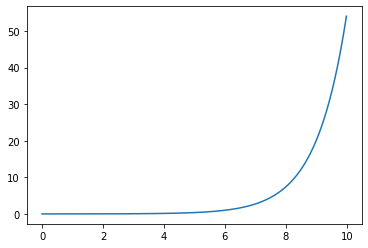

In [95]:
import matplotlib.pyplot as plt

t = 6
x = np.arange(0, 10, 0.01)
y = np.exp(x - t)

plt.plot(x, y)

print(np.exp(4 - t), np.exp(5 - t), np.exp(6 - t), np.exp(7 - t))

In [112]:
%%time

from pprint import pprint

premise1 = "Иван любит собирать грибы."
premise2 = "Ивана похитили инопланетяне и оставили одного в лесу в сапогах."
hypothesis = "На ногах у Ивана резиновые сапоги. Иван ходит по лесу с ножом и корзиной."

res1 = score(premise1, hypothesis, {hypothesis: test_embeds.numpy()})
res2 = score(premise2, hypothesis, {hypothesis: test_embeds.numpy()})

pprint({premise1: res1, premise2: res2})

{'Иван любит собирать грибы.': {'distance_score': 0.2787897435326176,
                                'final': 0.4082273466170368,
                                'nli_quality': 0.7620218694210052,
                                'perplexity_divisor': 1.0},
 'Ивана похитили инопланетяне и оставили одного в лесу в сапогах.': {'distance_score': 0.38493799386746763,
                                                                     'final': 0.5449441698242858,
                                                                     'nli_quality': 0.9325924515724182,
                                                                     'perplexity_divisor': 1.0}}
CPU times: user 1.45 s, sys: 0 ns, total: 1.45 s
Wall time: 727 ms


In [ ]:
import traceback

result = None
status_code = 200
try:
    result = score(input_premise, input_hypothesis, {hypothesis: test_embeds.numpy()})
except:
    result = traceback.format_exc()
    status_code = 500